## Load retrieval

In [429]:
# Load sentence retrieval result
model_name = ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"][0]
dataset_name = ["nfcorpus", "trec-covid"][0]
dropout=["", "-0.02", "-0.05"][0]
temp=[0.01, 0.05, 0.1][1]
import json 
import os 

with open(f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/corpus/{model_name}/{dataset_name}-d2d-retrieval.jsonl") as f:
    result = [json.loads(i) for i in f.readlines()]

## Load dataset

In [430]:
# Load csv file for recall, precision, and f1
import pandas as pd
path = f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/corpus/{model_name}/{dataset_name}.csv"
print(path)
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index("corpus-id")
df.sort_values("recall", ascending=True)

/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/corpus/bge-large-en-v1.5/nfcorpus.csv


,n-query,recall,precision
corpus-id,,,
MED-939,0,0,0
MED-5254,0,0,0
MED-1002,0,0,0
MED-734,0,0,0
MED-5247,0,0,0
...,...,...,...
MED-1665,0,0,0
MED-1040,0,0,0
MED-5208,0,0,0


## Load gradnorm

In [341]:
# Get grad norm dict
import pandas as pd
n_aug = 16
selection = ("min", "mean")[1] 

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_gradnorms(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            l = l.replace('\'', '"')
            item = json.loads(l)
            gradnorms.append(float(item["grad_norm"]))
        except Exception as e:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except Exception as e:
            continue

    gradnorms_selected = []
    ids_selected = []
    func = lambda x: min(x) if selection == "min" else sum(x) / len(x)
    for i in range(0, len(ids)-1, 16):
        gradnorms_selected.append(func(gradnorms[i:i+n_aug]))
        ids_selected.append(ids[i])
    gradnorm_dict = {cid: gradnorm for cid, gradnorm in zip(ids_selected, gradnorms_selected)}
            
    return gradnorm_dict

def get_recalls_and_precisions(pth):
    df = pd.read_csv(pth)
    df = df.drop('Unnamed: 0', axis=1)
    corpus_ids = df['corpus-id'].tolist()
    recalls = df['recall'].tolist()
    precisions = df['precision'].tolist()
    return dict(zip(corpus_ids, recalls)), dict(zip(corpus_ids, precisions))

## Retrieval results

In [318]:
gradnorm_dict = get_gradnorms(f"{model_raw_name}/{dataset_name}-result{dropout}-temp-{temp}") #-temp-0.02")

# Load csv file for recall, precision, and f1
import pandas as pd
path = f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_raw_name}/{dataset_name}-n-query-mt-2.csv"
recall_dict, precision_dict = get_recalls_and_precisions(path)

1938 1938


13.77396964926132 -1.229857492879654


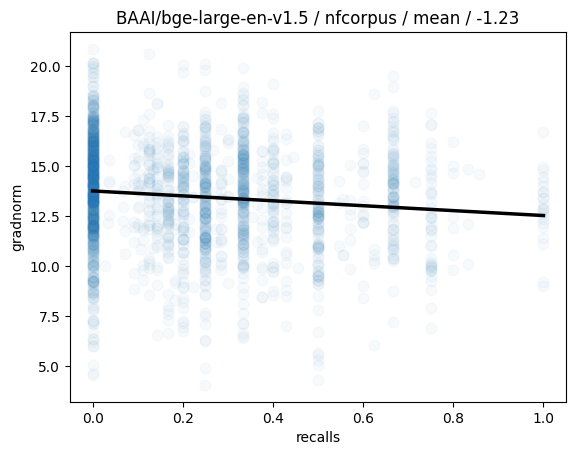

In [319]:
import matplotlib.pyplot as plt 

# Generate data
cids = sorted(gradnorm_dict.keys())
x = [recall_dict[i] for i in cids]
y = [gradnorm_dict[i] for i in cids]

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.03)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("recalls")
plt.ylabel("gradnorm")
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(a, b)

## Sort by wrongly retrieved counts

In [311]:
# Load retrieval result
import json
q2d_retrieval = f"/gallery_louvre/jinyoung.kim/ood/retrieval/results/{model_raw_name}/{dataset_name}-q2d-top-300.jsonl"
with open(q2d_retrieval) as f:
    file = [json.loads(i) for i in f.readlines()]
retrieval_results = {i["_id"]: [i["_id"] for i in i["retrieval"][:100]] for i in file}

In [322]:
gradnorm_dict = get_gradnorms(f"{model_raw_name}-corpus/{dataset_name}-result-temp-{temp}") #-temp-0.02")

In [275]:
# Load sentence retrieval result
model_name = ["BAAI/bge-large-en-v1.5", "intfloat/multilingual-e5-large", "facebook/contriever", "BAAI/bge-m3-unsupervised"][0]
model_raw_name = model_name.split('/')[-1]
dataset_name = ["nfcorpus", "trec-covid"][0]
dropout=["", "-0.02", "-0.05"][1]
temp = [0.01, 0.05, 0.1][1]
txt_name = f"{model_raw_name}/{dataset_name}-result{dropout}-temp-{temp}"
print(txt_name)

import pandas as pd
from collections import defaultdict

# Load queries that don't match failure documents
tsv_path = f"/gallery_louvre/dayoon.ko/research/sds/src/datasets/{dataset_name}/qrels/test.tsv"
df = pd.read_csv(tsv_path, sep='\t')
df = df[df["score"] >= 1]
query_ids = df['query-id'].tolist()
corpus_ids = df['corpus-id'].tolist()
scores = df['score'].tolist()

query_dict = defaultdict(list)
for query_id, corpus_id, score in zip(query_ids, corpus_ids, scores):
    query_dict[query_id] = corpus_id
related_doc_ids = set(corpus_ids)

# Wrong documents
wrong_doc_ids = []
for ret in retrieval_results.values():
    wrong_doc_ids.append(list(set(ret) - related_doc_ids))
wrong_doc_ids = sum(wrong_doc_ids, [])

wrong_doc_counts = defaultdict(int)
for i in wrong_doc_ids:
    wrong_doc_counts[i] += 1

bge-large-en-v1.5/nfcorpus-result-0.02-temp-0.05


In [324]:
# Load result
counts = []
gradnorms = []
cids = []
for i in result:
    cid = i["_id"]
    if cid not in gradnorm_dict:
        continue
    cids.append(cid)
    counts.append(wrong_doc_counts[cid])
    gradnorms.append(gradnorm_dict[cid])
print(len(gradnorms), len(counts))

436 436


14.172627732697329 -0.007332819415160678


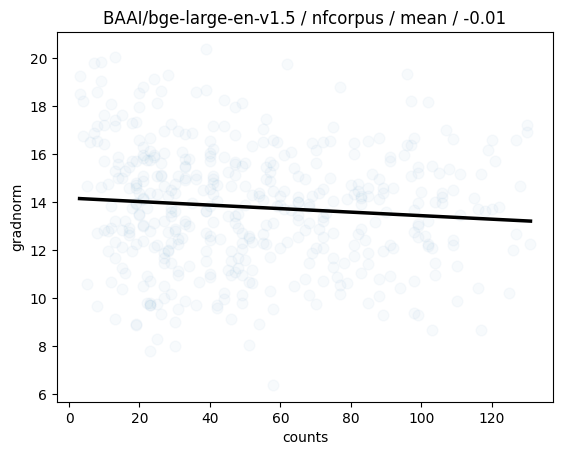

In [330]:
import matplotlib.pyplot as plt 

# Generate data
cids = sorted(gradnorm_dict.keys())
x = [wrong_doc_counts[i] for i in cids]
y = [gradnorm_dict[i] for i in cids]

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.03)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(min(counts), max(counts), num=100)

# Plot regression line
plt.xlabel("counts")
plt.ylabel("gradnorm")
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(a, b)

In [278]:
# Compared to baseline "a" for several intervals
interval = 20
for count_min in range(30, 140, interval):
    greater_than = 0
    lower_than = 0
    for c, g in zip(counts, gradnorms):
        if count_min <= c and c < count_min + interval // 2:
            if g >= a: greater_than += 1
            else: lower_than += 1
    print("Count min:", count_min, 
          "\t>= baseline:", round(greater_than / (greater_than + lower_than), 2), 
          "\t< baseline:", round(lower_than / (greater_than + lower_than), 2)
         )    

Count min: 30 	>= baseline: 0.44 	< baseline: 0.56
Count min: 50 	>= baseline: 0.46 	< baseline: 0.54
Count min: 70 	>= baseline: 0.32 	< baseline: 0.68
Count min: 90 	>= baseline: 0.46 	< baseline: 0.54
Count min: 110 	>= baseline: 0.36 	< baseline: 0.64
Count min: 130 	>= baseline: 0.67 	< baseline: 0.33


In [279]:
# Compare failure detection to random selection
import random

percent = 0.1

sorted_list = sorted(list(zip(cids, counts, gradnorms)), key=lambda x: x[2], reverse=True)
top_percent = sorted_list[:int(len(sorted_list) * percent)]
fail_counts = [c for _, c, _ in top_percent]
print("Avg counts for failure documents:", sum(fail_counts) / len(fail_counts))

shuffled_list = list(zip(cids, counts, gradnorms))
random.shuffle(shuffled_list)
random_percent = shuffled_list[:int(len(cids) * percent)]
fail_counts = [c for _, c, _ in random_percent]
print("Avg counts for random documents:", sum(fail_counts) / len(fail_counts))

Avg counts for failure documents: 36.348837209302324
Avg counts for random documents: 65.97674418604652


# Retrieval removal 

In [280]:
# Load retrieval result
q2d_retrieval = f"/gallery_louvre/jinyoung.kim/ood/retrieval/results/{model_raw_name}/{dataset_name}-q2d-top-300.jsonl"
with open(q2d_retrieval, 'r') as f:
    file = [json.loads(i) for i in f.readlines()]


In [281]:
# Load queries that don't match failure documents
tsv_path = f"/gallery_louvre/dayoon.ko/research/sds/src/datasets/{dataset_name}/qrels/test.tsv"
df = pd.read_csv(tsv_path, sep='\t')
df = df[df["score"] >= 1]
query_ids = df['query-id'].tolist()
corpus_ids = df['corpus-id'].tolist()
scores = df['score'].tolist()

query_dict = defaultdict(list)
for query_id, corpus_id, score in zip(query_ids, corpus_ids, scores):
    query_dict[query_id].append(corpus_id)
related_doc_ids = set(corpus_ids)

In [282]:
target_queries = []

gt = {}

for q_id, c_id_list in query_dict.items():
    target_queries.append(q_id)
    gt[q_id] = c_id_list


In [286]:
fail_document_ids = [i[0] for i in top_percent]
random_document_ids = [i[0] for i in random_percent]

retrieval_dict = {}
filtered_retrieval_dict = {}
top_k = 100

for item in file:
    ret = [i['_id'] for i in item['retrieval']][:top_k]
    filtered_ret = [i['_id'] for i in item['retrieval'] if i['_id'] not in fail_document_ids][:top_k]
    retrieval_dict[item['_id']] = ret
    filtered_retrieval_dict[item['_id']] = filtered_ret
    #assert len(filtered_ret) == 5


In [287]:
w_detected_failures, wo_detected_failures, total = 0, 0, 0
for _id in gt.keys():
    total += len(gt[_id])
    w_detected_failures += len(set(retrieval_dict[_id]).intersection(set(gt[_id]))) 
    wo_detected_failures += len(set(filtered_retrieval_dict[_id]).intersection(set(gt[_id]))) 
print(total, (w_detected_failures, wo_detected_failures))     g

12334 (2786, 2788)


### All document corpus
####### 쿼리 상관없이 전체에서 gradnorm 큰거 다 빼서 돌려보기!

In [502]:
# Get grad norm dict
n_aug = 16
selection = ("min", "mean")[1] 

print("Gradnorm")

gradnorm_dict = get_gradnorms( f"{model_raw_name}/{dataset_name}-result-temp-{temp}") #-temp-0.02")
recall_dict, precision_dict = get_recalls_and_precisions(f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_raw_name}/{dataset_name}-n-query-mt-2.csv")
print("When score > 0 exists:", len(gradnorm_dict), len(recall_dict))

gradnorm_dict_ = get_gradnorms( f"{model_raw_name}-corpus/{dataset_name}-result-temp-{temp}")
recall_dict_ = {k: 0. for k in gradnorm_dict_.keys()}
precision_dict_ = {k: 0. for k in gradnorm_dict_.keys()}
print("When all score == 0", len(gradnorm_dict_), len(recall_dict_))

gradnorm_dict.update(gradnorm_dict_)
recall_dict.update(recall_dict_)
precision_dict.update(precision_dict_)
print("All documents:", len(gradnorm_dict), len(recall_dict))

Gradnorm
When score > 0 exists: 1935 1938
When all score == 0 436 436
All documents: 2371 2374


In [533]:
# Compare failure detection to random selection
import random

percent = 0.1
print("#Failure Documents:", int(len(sorted_list) * percent))

sorted_list = sorted(gradnorm_dict.items(), key=lambda x: x[1], reverse=True)
top_percent = sorted_list[:int(len(sorted_list) * percent)]
fail_document_ids = [_id for _id, _ in top_percent]
print("Gradnorm from:", top_percent[0][1], "to:", top_percent[-1][1])

shuffled_list = list(gradnorm_dict.items()).copy()
random.shuffle(shuffled_list)
random_percent = shuffled_list[:int(len(shuffled_list) * percent)]
random_document_ids = [_id for _id, _ in random_percent]
random_gradnomrs = [gn for _, gn in random_percent]
print("Random selection avg gradnorm:", sum(random_gradnomrs) / len(random_gradnomrs))

sorted_list = sorted(gradnorm_dict.items(), key=lambda x: x[1])
top_percent = sorted_list[:int(len(sorted_list) * percent)]
well_document_ids = [_id for _id, _ in top_percent]
print("Gradnorm from:", top_percent[0][1], "to:", top_percent[-1][1])

#Failure Documents: 237
Gradnorm from: 21.007188856601715 to: 16.36379772424698
Random selection avg gradnorm: 13.345036911923549
Gradnorm from: 4.341805845499039 to: 10.483675181865692


In [534]:
def cal_mean(cids, dic, id_type, metric):
    lst = [dic[cid] for cid in cids]
    print("Type:", id_type, f"\t{metric} mean:", round(sum(lst) / len(lst), 3))

cal_mean(fail_document_ids, recall_dict, "Fail", "recall")
cal_mean(fail_document_ids, precision_dict, "Fail", "precision")
cal_mean(random_document_ids, recall_dict, "Random", "recall")
cal_mean(random_document_ids, precision_dict, "Random", "precision")
cal_mean(well_document_ids, recall_dict, "Well", "recall")
cal_mean(well_document_ids, precision_dict, "Well", "precision")


Type: Fail 	recall mean: 0.121
Type: Fail 	precision mean: 0.011
Type: Random 	recall mean: 0.216
Type: Random 	precision mean: 0.014
Type: Well 	recall mean: 0.212
Type: Well 	precision mean: 0.023


In [535]:
def compare_all_to_filtered_results(removal_ids):
    retrieval_dict = {}
    filtered_retrieval_dict = {}
    top_k = 10

    diff = 0
    for item in file:
        ret = [i['_id'] for i in item['retrieval'][:top_k]]
        filtered_ret_ = [i['_id'] for i in item['retrieval'][:top_k] if i['_id'] not in removal_ids] #[:top_k]
        diff += len(ret) - len(filtered_ret_)
        filtered_ret = [i['_id'] for i in item['retrieval'] if i['_id'] not in removal_ids][:top_k]
        retrieval_dict[item['_id']] = ret
        filtered_retrieval_dict[item['_id']] = filtered_ret
        #assert len(filtered_ret) == 5
    print("Diff:", diff)
    
    scores_all, scores_filtered, total, score_gap = 0, 0, 0, 0
    for _id in gt.keys():
        total += len(gt[_id])
        score_all = len(set(retrieval_dict[_id]) & (set(gt[_id]))) / len(set(retrieval_dict[_id]))
        score_filtered = len(set(filtered_retrieval_dict[_id]) & (set(gt[_id]))) / len(set(retrieval_dict[_id]))
        score_gap += score_filtered - score_all
        scores_all += score_all
        scores_filtered += score_filtered
        if score_wo_f - score_w_f > 0.01:
            print(score_wo_f - score_w_f)
        #print(len(set(retrieval_dict[_id]) & (set(gt[_id]))) / len(set(gt[_id])), len(set(filtered_retrieval_dict[_id]) & (set(gt[_id]))) / len(set(gt[_id])))
        
    print("All documents:", total)
    print("Results with all document corpus:", scores_all)
    print("Results without failure document corpus:", scores_filtered)
    print("Score gap:", score_gap)

In [536]:
compare_all_to_filtered_results(fail_document_ids)

Diff: 1968
All documents: 12334
Results with all document corpus: 86.49999999999997
Results without failure document corpus: 83.6
Score gap: -2.9000000000000004


In [537]:
compare_all_to_filtered_results(random_document_ids)

Diff: 2164
All documents: 12334
Results with all document corpus: 86.49999999999997
Results without failure document corpus: 82.69999999999996
Score gap: -3.8000000000000016


In [538]:
compare_all_to_filtered_results(well_document_ids)

Diff: 1842
All documents: 12334
Results with all document corpus: 86.49999999999997
Results without failure document corpus: 81.99999999999997
Score gap: -4.499999999999999
